In [1]:
from arcos4py.tools import track_events_image, remove_image_background
from arcos4py.tools._detect_events import upscale_image
from arcos4py.tools._cleandata import blockwise_median
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from napari.viewer import Viewer
from skimage import io
import napari
from scipy.ndimage import distance_transform_edt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [8]:
import numpy as np
from scipy.ndimage import binary_dilation, binary_fill_holes, binary_erosion
from skimage.morphology import erosion, remove_small_objects, square
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from skimage import io
import numpy as np
from skimage import io, exposure

import numpy as np
from scipy import ndimage
from skimage.morphology import closing

import numpy as np
from statsmodels.nonparametric.smoothers_lowess import lowess

import numpy as np
from scipy.signal import savgol_filter


def drop_scattered_small_labels(label_image, min_size=100):
    """
    Removes small scattered regions of each label from a labeled image.

    Parameters:
    - label_image: 2D numpy array representing the labeled image.
    - min_size: Minimum pixel size for keeping a scattered part of a label.

    Returns:
    - Processed image with small scattered labels dropped.
    """
    label_image = closing(label_image)
    unique_labels = np.unique(label_image)
    output_image = np.zeros_like(label_image)

    for label in unique_labels:
        if label == 0:  # Assuming 0 is the background
            continue

        # Create a binary image for the current label
        binary_mask = label_image == label

        # Identify separate regions of the current label
        labeled_mask, num_features = ndimage.label(binary_mask)

        # Measure the size of each region
        sizes = ndimage.sum(binary_mask, labeled_mask, range(num_features + 1))

        # Create a mask of regions to be kept for the current label
        mask_size = sizes >= min_size
        keep = mask_size[labeled_mask]

        # Update the output image with regions of the current label that are kept
        output_image[keep] = label

    return output_image


def process_time_series_label_images(time_series_label_images, min_size=100):
    """
    Processes a time-series of label images by removing small scattered labels.

    Parameters:
    - time_series_label_images: 3D numpy array representing a time-series of labeled images.
      The first dimension is time.
    - min_size: Minimum pixel size for keeping a scattered part of a label.

    Returns:
    - Processed time-series with small scattered labels dropped from each frame.
    """

    # Get the number of time points
    T = time_series_label_images.shape[0]

    # Initialize an output array of the same shape as the input
    output_images = np.zeros_like(time_series_label_images)

    for t in range(T):
        output_images[t] = drop_scattered_small_labels(time_series_label_images[t], min_size=min_size)

    return output_images


def filter_by_centroid_displacement(labeled_stack, min_distance):
    """
    Removes tracks from a labeled image stack if the total displacement of their centroid
    is less than the specified minimum distance.
    """
    labeled_stack = np.copy(labeled_stack)

    unique_labels = np.unique(labeled_stack)[1:]  # Exclude background (label 0)

    for label in unique_labels:
        # Get the coordinates of all pixels belonging to the current label (track) for each time point
        time_points = np.unique(np.where(labeled_stack == label)[0])

        centroids = []
        for t in time_points:
            coords = np.argwhere(labeled_stack[t] == label)
            centroid = coords.mean(axis=0)
            centroids.append(centroid)

        # Calculate the total centroid displacement by summing up the distances between consecutive time points
        total_distance = sum(np.linalg.norm(centroids[i + 1] - centroids[i]) for i in range(len(centroids) - 1))

        # If total displacement is less than min_distance, remove the track
        if total_distance < min_distance:
            labeled_stack[labeled_stack == label] = 0

    return labeled_stack


def filter_by_duration(labeled_stack, min_duration):
    """
    Removes tracks from a labeled image stack if their duration is less than the specified minimum.
    """
    labeled_stack = np.copy(labeled_stack)

    unique_labels = np.unique(labeled_stack)[1:]  # Exclude background (label 0)

    for label in unique_labels:
        # Get the coordinates of all pixels belonging to the current label (track) for each time point
        time_points = np.unique(np.where(labeled_stack == label)[0])

        # If the duration is less than min_duration, remove the track
        if len(time_points) < min_duration:
            labeled_stack[labeled_stack == label] = 0

    return labeled_stack


def smooth_segmentation(binary_objects, expand_iterations=1, remove_small=True, remove_small_objects_size=100):
    """
    Smooths the segmentation by removing small objects and filling holes.

    Parameters
    ----------
    binary_objects : numpy array
        Binary image of the segmented objects.
    remove_small : bool, optional
        Whether to remove small objects. The default is True.
    remove_small_objects_size : int, optional
        Size of the objects to remove. The default is 100.

    Returns
    -------
    binary_objects : numpy array
        Smoothed binary image of the segmented objects.
    """
    binary_objects = np.where(binary_objects == 1, 1, 0)
    if len(binary_objects.shape) == 3:
        for index, image in enumerate(binary_objects):
            image = binary_fill_holes(image)
            image = binary_dilation(image, square(5), iterations=expand_iterations)
            image = erosion(image, footprint=square(5))
            bool_img = image.astype(bool)
            if remove_small:
                image = remove_small_objects(bool_img, min_size=remove_small_objects_size**2)
            image = binary_fill_holes(image)
            binary = np.where(image, 1, 0)
            binary_objects[index] = binary
        return binary_objects
    else:
        binary_objects = binary_fill_holes(binary_objects)
        binary_objects = binary_dilation(binary_objects, square(5), iterations=expand_iterations)
        binary_objects = erosion(binary_objects, footprint=square(5))
        bool_img = binary_objects.astype(bool)
        if remove_small:
            binary_objects = remove_small_objects(bool_img, min_size=remove_small_objects_size**2)
        binary_objects = binary_fill_holes(binary_objects)
        binary_objects = np.where(binary_objects, 1, 0)
        return binary_objects

def bleach_correction_smooth(img_stack, window_length=11, polyorder=2):
    """
    Perform bleach correction on a t,y,x image stack using Savitzky-Golay smoothing.

    Parameters:
    - img_stack: 3D numpy array with shape (t, y, x)
    - window_length: Length of the filter window (must be odd).
    - polyorder: Order of the polynomial used to fit the samples.

    Returns:
    - Corrected 3D numpy array with same shape as img_stack
    """

    # Convert img_stack to float type for the correction
    img_stack = img_stack.astype(np.float64)

    # Calculate average intensity for each time point
    avg_intensities = img_stack.mean(axis=(1, 2))

    # Apply Savitzky-Golay filter to average intensities
    smoothed_intensities = savgol_filter(avg_intensities, window_length, polyorder)

    # Calculate correction factors
    correction_factors = smoothed_intensities / avg_intensities[0]

    # Apply correction to the image stack
    for i in range(img_stack.shape[0]):
        img_stack[i] /= correction_factors[i]

    return img_stack


def bleach_correction_loess(img_stack, frac=0.1):
    """
    Perform bleach correction on a t,y,x image stack using LOESS smoothing.

    Parameters:
    - img_stack: 3D numpy array with shape (t, y, x)
    - frac: The fraction of data used when estimating each y-value for the lowess fit.
            It determines the span of the window; for example, a value of 0.1 means
            each smoothed point uses 10% of the data points.

    Returns:
    - Corrected 3D numpy array with same shape as img_stack
    """

    # Convert img_stack to float type for the correction
    img_stack = img_stack.astype(np.float64)

    # Calculate average intensity for each time point
    avg_intensities = img_stack.mean(axis=(1, 2))

    # Time points
    t_values = np.arange(len(avg_intensities))

    # Apply LOESS smoothing to average intensities
    smoothed_intensities = lowess(avg_intensities, t_values, frac=frac, return_sorted=False)

    # Calculate correction factors
    correction_factors = smoothed_intensities / avg_intensities[0]

    # Apply correction to the image stack
    for i in range(img_stack.shape[0]):
        img_stack[i] /= correction_factors[i]

    return img_stack


def match_histogram(source, template, bins=65536):
    hist_source, bin_edges = np.histogram(source.ravel(), bins=bins, range=(0, bins))
    hist_template, _ = np.histogram(template.ravel(), bins=bins, range=(0, bins))

    cdf_source = hist_source.cumsum() / hist_source.sum()
    cdf_template = hist_template.cumsum() / hist_template.sum()

    lookup_table = np.zeros(bins, dtype=np.uint16)
    j = 0
    for i in range(bins):
        while cdf_template[j] < cdf_source[i] and j < bins:
            j += 1
        lookup_table[i] = j

    matched = lookup_table[source]
    return matched

In [4]:
stage_2_pos_12 = io.imread("transfer_187559_files_94515bab/lifeact_myosin_rgbd7_w15TIRF-GFP_s1_t1.TIF_-_Stage2__Position_12_.tiff")
# stable_fibres = io.imread("Cell1-stable-fibres.tif")



In [5]:
stage_2_pos_12.shape
# 721 timepoints
# 512x512 pixels
# 3 channels (myosin, rGBD, actin)

(721, 540, 540, 3)

In [12]:
from tqdm.auto import tqdm

myosin_bl = []
rGBD_bl = []
actin_bl = []

# split up image stack into channels
myosin = stage_2_pos_12[..., 0]
rGBD = stage_2_pos_12[..., 1]
actin = stage_2_pos_12[..., 2]

# reference images for histogram matching
reference_myosin = myosin[0]
reference_rGBD = rGBD[0]
reference_actin = actin[0]

# perform histogram matching
myosin_bl.append(np.stack([match_histogram(img, reference_myosin, bins=100000) for img in tqdm(myosin)]))
rGBD_bl.append(np.stack([match_histogram(img, reference_rGBD, bins=100000) for img in tqdm(rGBD)]))
actin_bl.append(np.stack([match_histogram(img, reference_actin, bins=100000) for img in tqdm(actin)]))

# processed images after histogram matching
myosin_bl = np.concatenate(myosin_bl)
rGBD_bl = np.concatenate(rGBD_bl)
actin_bl = np.concatenate(actin_bl)

  0%|          | 0/721 [00:00<?, ?it/s]

  0%|          | 0/721 [00:00<?, ?it/s]

  0%|          | 0/721 [00:00<?, ?it/s]

# Myosin Channel + after Histogram Matching

In [17]:
viewer = napari.Viewer()
viewer.add_image(myosin)
viewer.add_image(myosin_bl)

<Image layer 'myosin_bl' at 0x7fccd9045330>

# rGBD Channel + after Histogram Matching

In [15]:
viewer = napari.Viewer()
viewer.add_image(rGBD)
viewer.add_image(rGBD_bl)

<Image layer 'rGBD_bl' at 0x7fccf8fbd780>

# Actin Channel + after Histogram Matching

In [16]:
viewer = napari.Viewer()
viewer.add_image(actin)
viewer.add_image(actin_bl)

<Image layer 'actin_bl' at 0x7fccd8c62920>

## Edge detection

In [36]:
import cv2
import numpy as np

# Assuming 'images' is your 3D array with shape (721, 540, 540)
edges_detected = np.zeros_like(myosin)  # Create an array to store the edges

for i in range(myosin.shape[0]):  # Iterate through each slice
    slice = myosin[i, :, :]  # Get the ith slice
    
    # Convert the slice to 8-bit if it's not already, as Canny requires 8-bit input
    if slice.dtype != np.uint8:
        # Normalize the image data to 0 - 255
        slice_normalized = cv2.normalize(slice, None, 0, 255, cv2.NORM_MINMAX)
        # Convert to 8-bit
        slice_8bit = np.uint8(slice_normalized)
    else:
        slice_8bit = slice
    
    # Apply Canny edge detection
    edges = cv2.Canny(slice_8bit, threshold1=500, threshold2=600)
    
    # Store the edges in the corresponding position in the edges_detected array
    edges_detected[i, :, :] = edges




In [37]:
viewer = napari.Viewer()
viewer.add_image(edges_detected)
viewer.add_image(myosin)

<Image layer 'myosin' at 0x7fcd6dadfd90>

## Bin myosin channel

In [39]:
binned_myosin = blockwise_median(myosin, (1, 3, 3))

print(myosin.shape)
print(binned_myosin.shape)

(721, 540, 540)
(721, 180, 180)


In [40]:
viewer = napari.Viewer()
viewer.add_image(binned_myosin)
viewer.add_image(myosin)

<Image layer 'myosin' at 0x7fcd6dc240d0>

In [9]:
binned_actin = blockwise_median(actin_bl, (1, 3, 3))
binned_actin.shape
# io.imsave("binned_actin.tif", binned_actin)

(721, 180, 180)

In [19]:
viewer = napari.Viewer()
viewer.add_image(binned_actin)
viewer.add_image(actin_bl)

<Image layer 'actin_bl' at 0x7fd5a4003490>

In [41]:
myosin_bg = remove_image_background(binned_myosin, size=(20, 20, 20), filter_type="gaussian")
#actin_bg = np.where(actin_bg < 0, 0, actin_bg)

viewer = napari.Viewer()
viewer.add_image(myosin_bg)

<Image layer 'myosin_bg' at 0x7fccff75cac0>

In [79]:
viewer = napari.Viewer()
viewer.add_image(binned_myosin)
viewer.add_image(myosin_bg)
viewer.add_labels(track_events_image(myosin_bg > 10, eps=10, minClSz=50, predictor=True, nPrev=2))

100%|██████████| 721/721 [00:47<00:00, 15.20it/s]


<Labels layer 'Labels' at 0x7fcdacfa95a0>

In [48]:
from skimage.morphology import opening
from skimage.filters import gaussian


In [49]:
test = gaussian(opening(myosin_bg), sigma=1)

In [50]:
events_1 = track_events_image(test > 1, eps=5, minClSz=15, predictor=True, nPrev=3)

100%|██████████| 721/721 [00:46<00:00, 15.63it/s]


In [78]:
viewer = napari.Viewer()
viewer.add_image(test)
viewer.add_labels(events_1)

<Labels layer 'events_1' at 0x7fcdacde6290>

# Do seg with convpaint

In [52]:
viewer = napari.Viewer()
viewer.add_image(binned_myosin)

<Image layer 'binned_myosin' at 0x7fcd6ea82b00>

In [65]:
viewer = napari.Viewer()
viewer.add_image(test)
viewer.add_image(myosin_bg)
viewer.add_labels(events_1)

<Labels layer 'events_1' at 0x7fcdba80cb20>

In [80]:
viewer = napari.Viewer()
viewer.add_labels(events_1)
seg_smoothed = smooth_segmentation(viewer.layers["events_1"].data, expand_iterations=1)
viewer.add_labels(seg_smoothed, name="seg_smoothed")

<Labels layer 'seg_smoothed' at 0x7fccf064e6b0>

In [67]:
dist_transform = []
for i in seg_smoothed:
    dist_transform.append(distance_transform_edt(i).astype(np.uint16))

dist_transform = np.stack(dist_transform)

In [68]:
test_no_edge = np.where((dist_transform < 8) | (dist_transform > 120), 0, test)

In [69]:
viewer.add_image(test_no_edge, name="test_no_edge")

<Image layer 'test_no_edge' at 0x7fcdbabf7fa0>

In [70]:
events_1 = track_events_image(test_no_edge > 1, eps=5, minClSz=15, predictor=True, nPrev=3)

100%|██████████| 721/721 [00:00<00:00, 8203.44it/s]


In [71]:
events_1_filtered = process_time_series_label_images(events_1, 5)
events_1_filtered = filter_by_duration(events_1_filtered, 6)

In [72]:
viewer = napari.current_viewer()
viewer.add_labels(events_1, name="events_1")
viewer.add_labels(events_1_filtered, name="events_1_filtered")

<Labels layer 'events_1_filtered' at 0x7fcd71ec1120>

In [73]:
events_upscaled = []
for t in events_1:
    t_img = upscale_image(t, 10)
    events_upscaled.append(t_img)

events_upscaled = np.stack(events_upscaled)

In [75]:
viewer = napari.current_viewer()
viewer.add_labels(events_upscaled, name="events_1")

AttributeError: 'NoneType' object has no attribute 'add_labels'

In [76]:
viewer = napari.Viewer()
viewer.add_image(actin, name="binned_actin")
viewer.add_labels(events_upscaled, name="events_1")

<Labels layer 'events_1' at 0x7fcdba640670>

In [50]:
e.shape

(1320, 1160)

In [52]:
actin[0].shape

(1320, 1161)

In [53]:
from skimage.measure import regionprops_table

df_all = []
for idx, e in enumerate(events_upscaled):
    props = regionprops_table(e, properties=("label", "area", "centroid", 'intensity_mean'), intensity_image=actin[idx][:, :1160])
    df_temp = pd.DataFrame(props)
    df_temp["frame"] = idx * 30
    df_all.append(df_temp)

df_all = pd.concat(df_all)

df_all.rename(columns={"centroid-0": "x", "centroid-1": "y", "label": "id"}, inplace=True)

In [54]:
df_all

,id,area,x,y,intensity_mean,frame
0,1,10800.0,269.407407,484.129630,130.711019,0
1,2,7500.0,354.366667,99.700000,129.352267,0
2,3,7800.0,462.320513,605.141026,121.796410,0
3,4,16800.0,565.630952,242.773810,136.767024,0
4,5,8300.0,596.307229,893.295181,121.482530,0
...,...,...,...,...,...,...
1,76,2900.0,670.706897,921.396552,112.112759,4980
2,77,3100.0,697.080645,69.661290,132.752581,4980
3,78,2100.0,872.119048,220.690476,120.669524,4980
4,79,2600.0,235.653846,761.423077,116.023846,4980


In [55]:
import pandas as pd
import numpy as np


def get_summary_statistics(df):
    # Initializing lists to hold statistics for all objects
    obj_ids = []
    origin_x = []
    origin_y = []
    origin_t = []
    end_x = []
    end_y = []
    end_t = []
    lifetimes = []
    avg_sizes = []
    avg_velocities = []
    persistences = []

    for obj_id in df["id"].unique():
        obj_df = df[df["id"] == obj_id].sort_values(by="frame")

        # Origin and End points
        origin_x.append(obj_df.iloc[0]["x"])
        origin_y.append(obj_df.iloc[0]["y"])
        origin_t.append(obj_df.iloc[0]["frame"])
        end_x.append(obj_df.iloc[-1]["x"])
        end_y.append(obj_df.iloc[-1]["y"])
        end_t.append(obj_df.iloc[-1]["frame"])

        # Lifetime
        lifetime = obj_df["frame"].max() - obj_df["frame"].min() + 1
        lifetimes.append(lifetime)

        # Average size
        avg_sizes.append(obj_df["area"].mean())

        # Average velocity
        obj_df["dx"] = obj_df["x"].diff()
        obj_df["dy"] = obj_df["y"].diff()
        obj_df["dt"] = obj_df["frame"].diff()
        velocities = np.sqrt(obj_df["dx"] ** 2 + obj_df["dy"] ** 2) / obj_df["dt"]
        avg_velocities.append(velocities.mean())

        # Persistence
        net_displacement = np.linalg.norm(
            [obj_df["x"].iloc[-1] - obj_df["x"].iloc[0], obj_df["y"].iloc[-1] - obj_df["y"].iloc[0]]
        )
        total_distance = np.sum(np.sqrt(obj_df["x"].diff() ** 2 + obj_df["y"].diff() ** 2))
        persistence = net_displacement / total_distance if total_distance != 0 else 0  # To avoid division by zero
        persistences.append(persistence)

        # Add to object IDs list
        obj_ids.append(obj_id)

    # Creating the summary DataFrame
    summary_df = pd.DataFrame(
        {
            "id": obj_ids,
            "origin_x": origin_x,
            "origin_y": origin_y,
            "origin_t": origin_t,
            "end_x": end_x,
            "end_y": end_y,
            "end_t": end_t,
            "lifetime": lifetimes,
            "avg_size": avg_sizes,
            "avg_velocity": avg_velocities,
            "persistence": persistences,
        }
    )

    return summary_df


summary_df = get_summary_statistics(df_all)

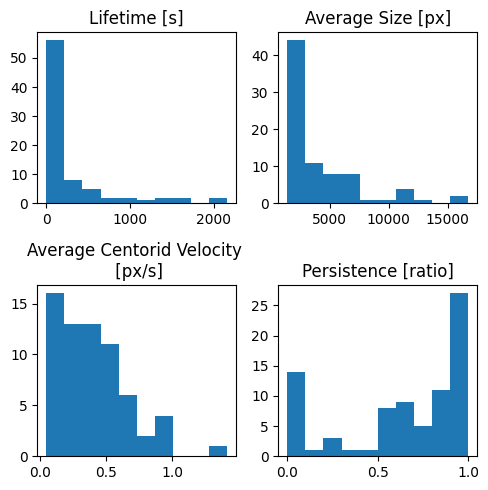

In [56]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(5, 5), sharex=False)

axs = axs.flatten()
axs[0].hist(summary_df["lifetime"], bins=10)
axs[0].set_title("Lifetime [s]")

axs[1].hist(summary_df["avg_size"], bins=10)
axs[1].set_title("Average Size [px]")

axs[2].hist(summary_df["avg_velocity"], bins=10)
axs[2].set_title("Average Centorid Velocity \n [px/s]")

axs[3].hist(summary_df["persistence"], bins=10)
axs[3].set_title("Persistence [ratio]")

plt.tight_layout()
# plt.show()
plt.savefig("summary_stats_fibers.png")

In [57]:
summary_df.persistence.mean()

0.6426804493449293

In [58]:
# add origin and end points to to napari at their respective frames
viewer = napari.current_viewer()
viewer.add_points(
    summary_df[["origin_t", "origin_x", "origin_y"]].values,
    name="origin",
    face_color="red",
    symbol="cross",
    size=30,
    n_dimensional=True,
)
viewer.add_points(
    summary_df[["end_t", "end_x", "end_y"]].values,
    name="end",
    face_color="blue",
    symbol="cross",
    size=30,
    n_dimensional=True,
)

<Points layer 'end' at 0x1a4dcba9810>

In [ ]:
import warnings


class CameraSetter:
    """A context manager to adjust viewer camera settings before rendering."""

    def __init__(self, viewer):
        self.viewer = viewer
        # get initial settings
        self.center = viewer.camera.center
        self.zoom = viewer.camera.zoom
        self.angles = viewer.camera.angles

        self.input_canvas_size = viewer.window.qt_viewer.canvas.size

        extent = viewer._sliced_extent_world[:, -2:]
        scene_size = (extent[1] - extent[0]) / viewer.window.qt_viewer.canvas.pixel_scale  # adjust for pixel scaling
        grid_size = list(viewer.grid.actual_shape(len(viewer.layers)))

        # Adjust grid_size if necessary
        if len(scene_size) > len(grid_size):
            grid_size = [1] * (len(scene_size) - len(grid_size)) + grid_size

        # calculate target size i.e the size the canvas should be to fit the whole scene
        self.target_size = tuple((scene_size[::-1] / 2 * grid_size[::-1]).astype(int))
        self.center = viewer.camera.center
        self.zoom = viewer.camera.zoom
        self.angles = viewer.camera.angles

    # copied from viewer.reset_view and modified without padding
    def _center_on_canvas(self):
        """Reset the camera view."""
        extent = self.viewer._sliced_extent_world
        scene_size = extent[1] - extent[0]
        corner = extent[0]
        grid_size = list(self.viewer.grid.actual_shape(len(self.viewer.layers)))
        if len(scene_size) > len(grid_size):
            grid_size = [1] * (len(scene_size) - len(grid_size)) + grid_size
        size = np.multiply(scene_size, grid_size)
        center = np.add(corner, np.divide(size, 2))[-self.viewer.dims.ndisplay :]
        center = [0] * (self.viewer.dims.ndisplay - len(center)) + list(center)
        self.viewer.camera.center = center

        if np.max(size) == 0:
            self.viewer.camera.zoom = np.min(self.viewer._canvas_size)
        else:
            scale = np.array(size[-2:])
            scale[np.isclose(scale, 0)] = 1
            self.viewer.camera.zoom = 1 * np.min(np.array(self.viewer._canvas_size) / scale)
        self.viewer.camera.angles = (0, 0, 90)

    def __enter__(self):
        """Set up the viewer for rendering."""
        self.viewer.window.qt_viewer.canvas.size = self.target_size
        self._center_on_canvas()

    def __exit__(self, exc_type, exc_val, exc_tb):
        """Reset the viewer after rendering."""
        self.viewer.window.qt_viewer.canvas.size = self.input_canvas_size
        self.viewer.camera.center = self.center
        self.viewer.camera.zoom = self.zoom
        self.viewer.camera.angles = self.angles


def render_as_rgb(viewer, axis: None | int = None):
    """Render the viewer for a single timepoint."""
    with CameraSetter(viewer):
        if axis is not None:
            rgb = []
            for i in range(viewer.dims.range[axis][1].astype(int)):
                viewer.dims.set_current_step(axis, i)
                rendered_img = viewer.window.qt_viewer.canvas.render(alpha=False)
                rgb.append(rendered_img)
            rendered_img = np.stack(rgb)
        else:
            rendered_img = viewer.window.qt_viewer.canvas.render(alpha=False)
    return rendered_img


# Usage
rgb = []
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    rendered_img = render_as_rgb(viewer, 0)

In [ ]:
events_filtered = remove_short_lived_labels(events_1)
viewer.add_labels(events_filtered, name="events_filtered")

In [ ]:
import cv2

# Read the first image to get the width, height
frame = rendered_img[0]
h, w, layers = frame.shape

# Define the codec and create a VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out = cv2.VideoWriter("origin_end_waves_stable.mp4", fourcc, 12, (w, h))

for image in rendered_img:
    out.write(cv2.cvtColor(image, cv2.COLOR_RGBA2BGR))  # Write out frame to video

# Release everything when the job is finished
out.release()
cv2.destroyAllWindows()

In [ ]:
viewer = napari.Viewer()
viewer.add_image(actin, colormap="gray_r", name="actin")
viewer.add_image(myosin, colormap="gray_r", name="myosin")
viewer.add_image(rGBD, colormap="gray_r", name="rGBD")
viewer.add_labels(events_upscaled, name="events_filtered")

In [ ]:
io.imshow(rendered_img)

In [15]:
from __future__ import annotations
import napari
import numpy as np
import warnings
from skimage import io
from magicgui import magicgui
from pathlib import Path
from typing import Optional

viewer = napari.Viewer()

class CameraSetter:
    """A context manager to adjust viewer camera settings before rendering."""

    def __init__(self, viewer, upsample_factor=1):
        self.viewer = viewer
        # get initial settings
        self.center = viewer.camera.center
        self.zoom = viewer.camera.zoom
        self.angles = viewer.camera.angles

        self.input_canvas_size = viewer.window.qt_viewer.canvas.size

        extent = viewer._sliced_extent_world[:, -2:]
        scene_size = (extent[1] - extent[0]) / viewer.window.qt_viewer.canvas.pixel_scale * upsample_factor # adjust for pixel scaling
        grid_size = list(viewer.grid.actual_shape(len(viewer.layers)))

        # Adjust grid_size if necessary
        if len(scene_size) > len(grid_size):
            grid_size = [1] * (len(scene_size) - len(grid_size)) + grid_size

        # calculate target size i.e the size the canvas should be to fit the whole scene
        self.target_size = tuple((scene_size[::-1] * grid_size[::-1]).astype(int))
        self.center = viewer.camera.center
        self.zoom = viewer.camera.zoom
        self.angles = viewer.camera.angles

    # copied from viewer.reset_view and modified without padding
    def _center_on_canvas(self):
        """Reset the camera view."""
        extent = self.viewer._sliced_extent_world
        scene_size = extent[1] - extent[0]
        corner = extent[0]
        grid_size = list(self.viewer.grid.actual_shape(len(self.viewer.layers)))
        if len(scene_size) > len(grid_size):
            grid_size = [1] * (len(scene_size) - len(grid_size)) + grid_size
        size = np.multiply(scene_size, grid_size)
        center = np.add(corner, np.divide(size, 2))[-self.viewer.dims.ndisplay :]
        center = [0] * (self.viewer.dims.ndisplay - len(center)) + list(center)
        self.viewer.camera.center = center

        if np.max(size) == 0:
            self.viewer.camera.zoom = np.min(self.viewer._canvas_size)
        else:
            scale = np.array(size[-2:])
            scale[np.isclose(scale, 0)] = 1
            self.viewer.camera.zoom = 1 * np.min(np.array(self.viewer._canvas_size) / scale)
        self.viewer.camera.angles = (0, 0, 90)

    def __enter__(self):
        """Set up the viewer for rendering."""
        self.viewer.window.qt_viewer.canvas.size = self.target_size
        self._center_on_canvas()

    def __exit__(self, exc_type, exc_val, exc_tb):
        """Reset the viewer after rendering."""
        self.viewer.window.qt_viewer.canvas.size = self.input_canvas_size
        self.viewer.camera.center = self.center
        self.viewer.camera.zoom = self.zoom
        self.viewer.camera.angles = self.angles

def get_choices(gui):
    """Return the choices for the axis dropdown."""
    viewer: napari.Viewer
    viewer = napari.current_viewer()
    choices = []
    for i, axis in enumerate(viewer.dims.axis_labels[:-2]):
        if axis is not None:
            choices.append(i)
    return choices

@magicgui(call_button="export", directory={"mode": "d", "label": "Choose a directory"}, axis={"choices": get_choices}, output_type={"choices": ["tif", "mp4"]})
def render_as_rgb(viewer: napari.Viewer, axis: Optional[int], directory=Path(), name: str = "out",  output_type = "mp4", fps: int = 12, upsample_factor: int = 1):
    """Render the viewer for a single timepoint."""
    axis = int(axis) if axis is not None else None
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        with CameraSetter(viewer, upsample_factor):
            if axis is not None:
                rgb = []
                for i in range(viewer.dims.range[axis][1].astype(int)):
                    viewer.dims.set_current_step(axis, i)
                    rendered_img = viewer.window.qt_viewer.canvas.render(alpha=False)
                    rgb.append(rendered_img)
                rendered_img = np.stack(rgb)
            else:
                rendered_img = viewer.window.qt_viewer.canvas.render(alpha=False)

    outpath = directory.joinpath(f"{name}.{output_type}").as_posix()
    if output_type == "tif":
        io.imsave(outpath, rendered_img)
    elif output_type == "mp4":
        if axis is None:
            raise ValueError("You must specify an axis to export as mp4")
        try:
            import cv2
        except ImportError:
            raise ImportError("You must install opencv to export as mp4, try `pip install opencv-python`")

        # Read the first image to get the width, height
        frame = rendered_img[0]
        h, w, layers = frame.shape

        # Define the codec and create a VideoWriter object
        fourcc = cv2.VideoWriter_fourcc(*"mp4v")
        out = cv2.VideoWriter(outpath, fourcc, fps, (w, h))

        for image in rendered_img:
            out.write(cv2.cvtColor(image, cv2.COLOR_RGBA2BGR))  # Write out frame to video

        # Release everything when the job is finished
        out.release()
        try:
            cv2.destroyAllWindows()
        except:
            print("could not close cv2 windows")


if globals().get("viewer") is None:
    viewer = napari.Viewer()
else:
    viewer = globals()["viewer"]

viewer.window.add_dock_widget(render_as_rgb, name="render as rgb")
viewer.show(block=True)

could not close cv2 windows
